In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import datetime as dt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
from scipy import stats
from pylab import savefig

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, make_scorer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('ggplot')

## Import the cleaned data set

In [2]:
df = pd.read_csv("cleaned_CA_data.csv")

In [3]:
#Trial 1
# df = df.drop(columns=['Unnamed: 0'])

#Trial 2 - what if we take out "Distance"?
df = df.drop(columns=['Unnamed: 0', 'Distance(mi)'])

Severity 3 0.2770421287637723
Severity 2 0.7055684028649708
Severity 1 0.007088716397622769
Severity 4 0.010300751973634073


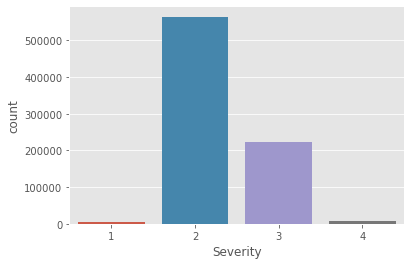

In [62]:
for i in df['Severity'].unique():
    print('Severity', i, df[df['Severity'] == i]['Hour'].count()/len(df))

sns.countplot(x="Severity", data=df)

#.get_figure().savefig('Severity.png') at the end of line 4 to save figure


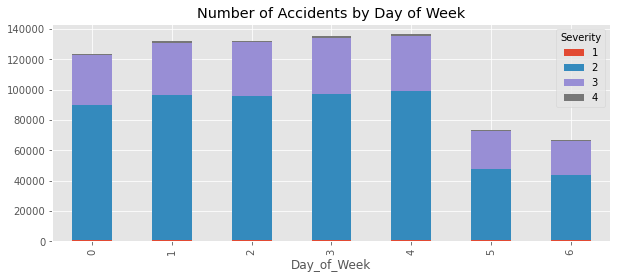

In [5]:
df.groupby(['Day_of_Week','Severity']).size().unstack().plot(kind='bar',stacked=True, title="Number of Accidents by Day of Week", figsize=(10,4))
plt.show()

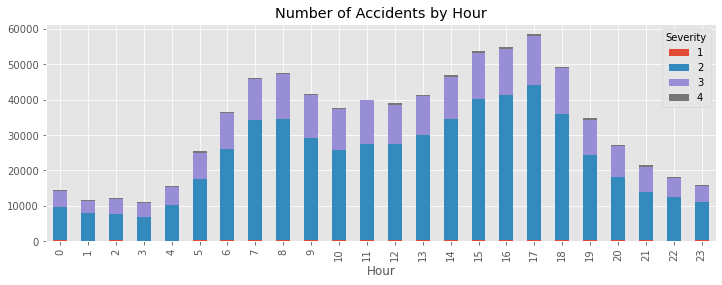

In [6]:
df.groupby(['Hour','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4), title="Number of Accidents by Hour")
plt.show()

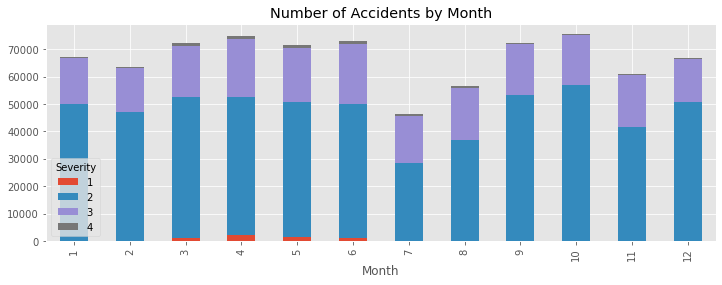

In [7]:
df.groupby(['Month','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4), title="Number of Accidents by Month")
plt.show()

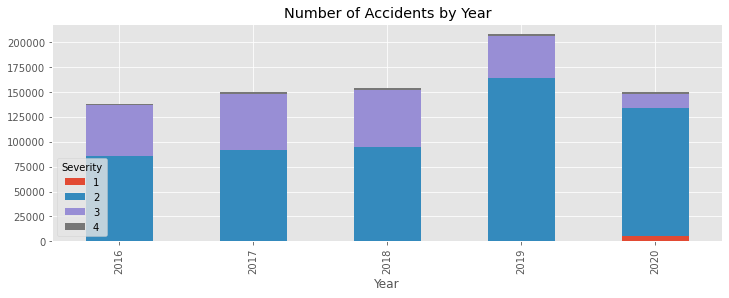

In [8]:
df.groupby(['Year','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4), title="Number of Accidents by Year")
plt.show()

In [9]:
#plot Severity distribution and print count for each
# df['County'].plot(kind="hist")
county_ct = dict()
for i in df['County'].unique():
#     print('County', i, df[df['County'] == i]['Severity'].count())
    county_ct[i] = df[df['County'] == i]['Severity'].count()

sorted_x = sorted(county_ct.items(), key=lambda kv: kv[1])
sorted_x

'''
Top ounties with the most accident records:
1. LA
2. Alameda
3. Orange
4. San Diego
5. San Bernardino
6. Sacramento
7. Riverside
8. Santa Clara
9. Contra Costa
10. San Mateo
'''

'\nTop ounties with the most accident records:\n1. LA\n2. Alameda\n3. Orange\n4. San Diego\n5. San Bernardino\n6. Sacramento\n7. Riverside\n8. Santa Clara\n9. Contra Costa\n10. San Mateo\n'

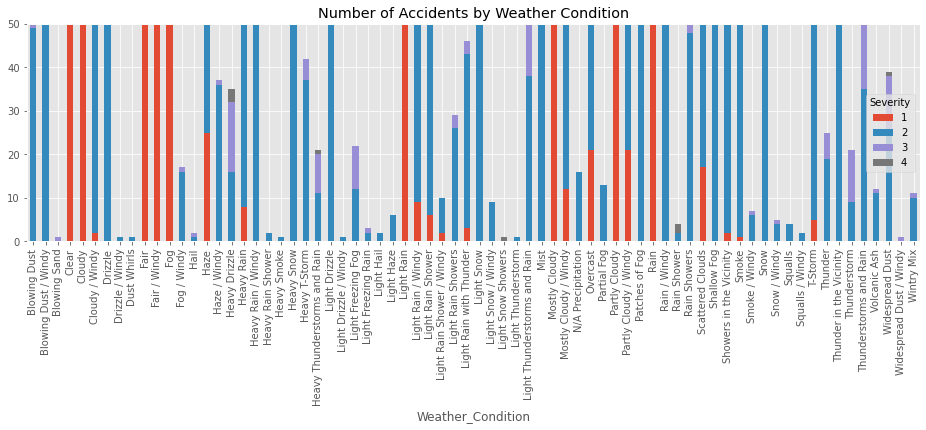

In [10]:
df.groupby(['Weather_Condition','Severity']).size().unstack().plot(kind='bar',stacked=True,
                                                       figsize=(16,4), ylim=(0, 50), title="Number of Accidents by Weather Condition")
plt.show()

### Let's run a Decision Tree Classifier just to see what the results look like:
- Accuracy: 0.858
- What does this mean? Over 560k of the 800k are Severity == 2...

In [11]:
cols = df.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = df[X_col]
y = df[y_col]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=462, stratify=y)

In [13]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, pred)))

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print("My prediction: {}".format(clf.predict(X_test)[0:20]))
print("Actual result: {}".format(y_test[0:20]))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

Accuracy = 0.814
F1 score: 0.8148684770600304
Recall score: 0.8136746840440364
My prediction: [3 3 2 2 2 2 3 3 2 2 2 3 2 2 2 2 2 2 2 1]
Actual result: [3 2 2 2 2 2 3 3 2 2 2 3 2 2 2 2 2 2 2 2]
Accuracy per class: [0.53618031 0.87591789 0.69263761 0.24441786]


In [14]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)

# Accuracy score
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

accuracy = 0.8090171758109411
F1 score: 0.8019951342198148
Recall score: 0.8090171758109411
Accuracy per class: [0.75276753 0.84000237 0.70865049 0.77401894]


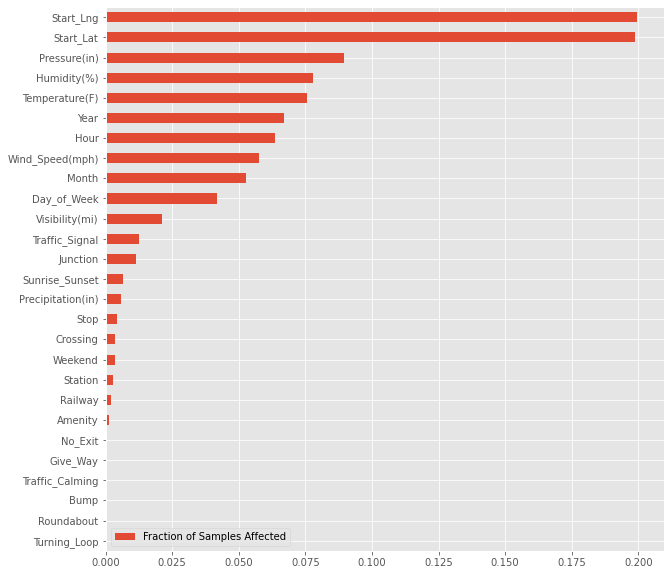

In [15]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(10,10))

## Turn `Weather_Condition`  into smaller clusters
- Separate Weather Conditions into "good" and "bad"
    - Maybe break it down further? "Good", "Mild", and "Bad"?

In [16]:
pd.set_option('display.max_rows', None)
df.groupby('Weather_Condition').count()

,Severity,Start_Lat,Start_Lng,Description,Street,City,County,Temperature(F),Humidity(%),Pressure(in),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Date,Hour,Day_of_Week,Month,Year,Weekend
Weather_Condition,,,,,,,,,,,,,,,,,,,,,
Blowing Dust,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
Blowing Dust / Windy,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
Blowing Sand,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Clear,253069,253069,253069,253069,253069,253069,253069,253069,253069,253069,...,253069,253069,253069,253069,253069,253069,253069,253069,253069,253069
Cloudy,46052,46052,46052,46052,46052,46052,46052,46052,46052,46052,...,46052,46052,46052,46052,46052,46052,46052,46052,46052,46052
Cloudy / Windy,230,230,230,230,230,230,230,230,230,230,...,230,230,230,230,230,230,230,230,230,230
Drizzle,313,313,313,313,313,313,313,313,313,313,...,313,313,313,313,313,313,313,313,313,313
Drizzle / Windy,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Dust Whirls,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [17]:
len(set(df['Weather_Condition']))

72

In [18]:
weather_vals = df['Weather_Condition'].values
good_weather = list(set(['Clear', 'Fair', 'Fair / Windy']))
mild_weather = list(set(['Blowing Dust', 'Partly Cloudy', 'Scattered Clouds', 'Mostly Cloudy',
                'Overcast', 'Mist', 'Smoke', 'Smoke / Windy', 'Shallow Fog', 'Cloudy / Windy', 'Drizzle',
                'Cloudy', 'Mostly Cloudy / Windy', 'N/A Precipitation', 'Partial Fog',
                'Partly Cloudy', 'Partly Cloudy / Windy', 'Patches of Fog', 'Showers in the Vicinity']))
bad_weather = list(set(['Blowing Sand', 'Blowing Dust / Windy', 'Dust Whirls', 'Fog', 'Fog / Windy',
             'Hail', 'Haze', 'Haze / Windy', 'Heavy Drizzle', 'Heavy Rain', 'Heavy Rain / Windy',
             'Heavy Rain Shower', 'Heavy Smoke', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain',
             'Light Drizzle', 'Light Drizzle / Windy', 'Light Freezing Fog', 'Light Freezing Rain',
             'Light Hail', 'Light Haze', 'Light Rain', 'Light Rain / Windy', 'Light Rain Shower',
             'Light Rain Shower / Windy', 'Light Rain Showers', 'Light Rain with Thunder',
             'Light Snow', 'Light Snow / Windy', 'Light Snow Showers', 'Light Thunderstorm',
             'Light Thunderstorms and Rain', 'Drizzle / Windy', 'Rain', 'Rain / Windy', 'Rain Shower',
             'Rain Showers', 'Snow', 'Snow / Windy', 'Squalls', 'Squalls / Windy', 'T-Storm', 'Thunder',
             'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms and Rain', 'Volcanic Ash', 
             'Widespread Dust', 'Widespread Dust / Windy', 'Wintry Mix']))

# bad_weather = list(set([i for i in df['Weather_Condition'].values if i not in good_weather]))

counter_good = 0
counter_mild = 0
counter_bad = 0


for i in df['Weather_Condition'].values:
    if i in good_weather:
        counter_good += 1
    elif i in mild_weather:
        counter_mild += 1
    else:
        counter_bad += 1
        
total_counter = counter_good + counter_mild + counter_bad
        
print('Total # of Weather Conditions:', len(good_weather) +len(mild_weather) + len(bad_weather))
print('Good:', counter_good, ',', round(100*counter_good/total_counter, 2), '% of total')
print('Mild:', counter_mild, ',', round(100*counter_mild/total_counter, 2), '% of total')
print('Bad:', counter_bad, ',', round(100*counter_bad/total_counter, 2), '% of total')

Total # of Weather Conditions: 72
Good: 434765 , 54.32 % of total
Mild: 290434 , 36.28 % of total
Bad: 75228 , 9.4 % of total


### Let's test it out. 
- Switch Weather Condition values to either 0 = "good", 1 = "mild", and 2 = "bad"  

In [19]:
def simplify_vals(col:str, value:list, replacement:list, df=df):
    df[col] = df[col].replace(value, replacement*len(value))

In [20]:
#Replace Weather_Condition values with either 0 (good) or 1 (bad)
simplify_vals(col='Weather_Condition', value=good_weather, replacement=[0])
simplify_vals(col='Weather_Condition', value=mild_weather, replacement=[1])
simplify_vals(col='Weather_Condition', value=bad_weather, replacement=[2])

In [21]:
#Replace Severity values with either 0 (low - 1,2) or 1 (high - 3,4)
# simplify_vals(col='Severity', value=sev12, replacement=[0])
# simplify_vals(col='Severity', value=sev34, replacement=[1])

In [22]:
df['Severity'].unique()

array([3, 2, 1, 4])

In [23]:
df['Weather_Condition'].unique()

array([0, 1, 2])

### Re-run the Decision Tree Classifier and RF Classifier to compare results

In [24]:
cols = df.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = df[X_col]
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=462, stratify=y)

Accuracy = 0.813
F1 score: 0.8145482989323864
Recall score: 0.8133248711939113
[[[197930    758]
  [   502    917]]

 [[ 41560  17358]
  [ 18886 122303]]

 [[127318  17351]
  [ 16552  38886]]

 [[196158   1888]
  [  1415    646]]]
              precision    recall  f1-score   support

           1     0.5475    0.6462    0.5928      1419
           2     0.8757    0.8662    0.8709    141189
           3     0.6915    0.7014    0.6964     55438
           4     0.2549    0.3134    0.2812      2061

    accuracy                         0.8133    200107
   macro avg     0.5924    0.6318    0.6103    200107
weighted avg     0.8159    0.8133    0.8145    200107

Accuracy per class: [0.54746269 0.87571333 0.69146647 0.25493291]


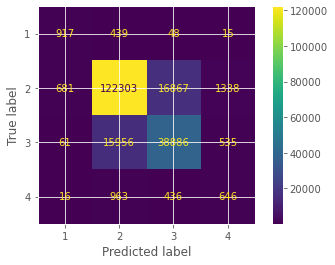

In [25]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, pred)))

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

accuracy = 0.8021058733577536
F1 score: 0.7936266969123753
Recall score: 0.8021058733577536
[[[198384    304]
  [   595    824]]

 [[ 33034  25884]
  [ 13223 127966]]

 [[131403  13266]
  [ 24257  31181]]

 [[197900    146]
  [  1525    536]]]
              precision    recall  f1-score   support

           1     0.7305    0.5807    0.6470      1419
           2     0.8318    0.9063    0.8675    141189
           3     0.7015    0.5624    0.6243     55438
           4     0.7859    0.2601    0.3908      2061

    accuracy                         0.8021    200107
   macro avg     0.7624    0.5774    0.6324    200107
weighted avg     0.7945    0.8021    0.7936    200107

Accuracy per class: [0.73049645 0.83175821 0.70153216 0.78592375]


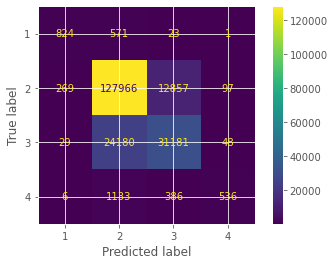

In [26]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=20,
                            max_features='auto',
                            n_jobs=-1,
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)

# Accuracy
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

plot_confusion_matrix(rf, X_test, y_test)
plt.show()

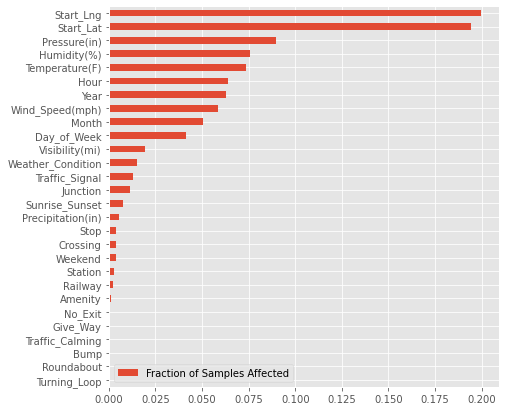

In [27]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(7,7))

## Let's try removing the outliers from the numerical columns to see if our scores improve
- numerical columns = ['Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)']
- Distance max = 227.21 mi
- Temp max = 127.4 F (this is okay)
- Visibility max = 140 mi
- Wind Speed max = 822.8 mph


In [28]:
pd.set_option('display.max_columns', None)
df.describe()

,Severity,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Day_of_Week,Month,Year,Weekend
count,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.0,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000
mean,2.290555,35.532484,-119.486306,64.973985,59.572757,29.794128,9.149454,7.201091,0.002962,0.550819,0.006425,0.000216,0.032059,0.000795,0.135300,0.000422,0.010813,0.000022,0.019392,0.017773,0.000292,0.081322,0.0,0.321341,12.510576,2.644367,6.445458,2018.102427,0.916432
std,0.490828,2.035670,1.952353,12.498112,23.429945,0.566702,2.357273,5.399943,0.034612,0.659839,0.079900,0.014700,0.176157,0.028177,0.342044,0.020545,0.103422,0.004742,0.137899,0.132126,0.017096,0.273329,0.0,0.466992,5.603003,1.838686,3.466271,1.370322,0.276739
min,1.000000,32.542587,-124.369232,-29.900000,1.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,2016.000000,0.000000
25%,2.000000,33.956570,-121.648949,56.000000,42.000000,29.800000,10.000000,4.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,8.000000,1.000000,3.000000,2017.000000,1.000000
50%,2.000000,34.164516,-118.387817,64.000000,62.000000,29.920000,10.000000,7.202019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,13.000000,3.000000,6.000000,2018.000000,1.000000
75%,3.000000,37.698586,-117.916377,73.000000,78.000000,30.030000,10.000000,9.200000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,17.000000,4.000000,10.000000,2019.000000,1.000000
max,4.000000,42.005420,-114.300598,127.400000,100.000000,33.040000,140.000000,822.800000,24.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,23.000000,6.000000,12.000000,2020.000000,1.000000


In [29]:
q = df['Visibility(mi)'].quantile(0.99)
#99th_q_dist = 1.62
#99th_q_temp = 97.0
#99th_q_visib = 10.0
#99th_q_windspeed = 21.0

# df2 = df[df['Distance(mi)'] < 1.62]  #Trial 1
# df3 = df2[df2['Visibility(mi)'] < 11.0] #Trial 1
df3 = df[df['Visibility(mi)'] < 11.0]  #Trial 2
cldf = df3[df3['Wind_Speed(mph)'] < 21.0]
#cldf = cleaned dataset with no outliers

In [30]:
df.groupby('Year')['Severity'].value_counts()

Year  Severity
2016  2            85602
      3            51348
      4             1182
      1               96
2017  2            91464
      3            56870
      4             1562
      1               85
2018  2            95023
      3            57236
      4             1552
      1               39
2019  2           164393
      3            41975
      4             1928
      1               18
2020  2           128274
      3            14323
      1             5436
      4             2021
Name: Severity, dtype: int64

In [31]:
#get rid of 2020 data --> severity 1 is too imbalaced over the time period, most are in 2020
cldf = cldf[cldf['Year'] < 2020]

In [32]:
cldf.groupby('Year')['Severity'].value_counts()
#much more balanced

Year  Severity
2016  2            84910
      3            51011
      4             1168
      1               94
2017  2            90194
      3            56324
      4             1541
      1               85
2018  2            94227
      3            56869
      4             1544
      1               39
2019  2           162179
      3            41434
      4             1892
      1               17
Name: Severity, dtype: int64

In [33]:
# cldf.to_csv('final_no_outliers_CA_data.csv')

In [34]:
for i in cldf['Severity'].unique():
    print('Severity', i, 
          cldf[cldf['Severity'] == i]['Start_Lat'].count())

Severity 3 205638
Severity 2 431510
Severity 1 235
Severity 4 6145


## Run Logististic Reg, Decision Tree, and RF Classifiers WITHOUT outliers

In [35]:
cols = cldf.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = cldf[X_col]
y = cldf[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y, test_size=0.4)

In [36]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print('Accuracy Score:', accuracy_score(y_test, lr_pred))

# Checking unique values
predictions = pd.DataFrame(lr_pred)
print('Prediction value counts:', predictions[0].value_counts())
# f1 score
print('F1 Score:', f1_score(y_test, lr_pred, average='weighted'))

# recall score
print('Recall Score:', recall_score(y_test, lr_pred, average='weighted'))

Accuracy Score: 0.6751006169098566
Prediction value counts: 2    242762
3     14650
Name: 0, dtype: int64
F1 Score: 0.5872102083343045
Recall Score: 0.6751006169098566


In [37]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print("Accuracy = {:.3f}".format(accuracy_score(y_test, clf_pred)))

predictions = pd.DataFrame(clf_pred)
print('Prediction value counts:', predictions[0].value_counts())
# f1 score
print('F1 Score:', f1_score(y_test, clf_pred, average='weighted'))

# recall score
print('Recall Score:', recall_score(y_test, clf_pred, average='weighted'))

print(classification_report(y_test, clf_pred, digits=4))

matrix = confusion_matrix(y_test, clf_pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

Accuracy = 0.808
Prediction value counts: 2    171234
3     83171
4      2902
1       105
Name: 0, dtype: int64
F1 Score: 0.8086526167163581
Recall Score: 0.8078450111105931
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        94
           2     0.8637    0.8568    0.8602    172605
           3     0.7145    0.7224    0.7184     82255
           4     0.2195    0.2592    0.2377      2458

    accuracy                         0.8078    257412
   macro avg     0.4494    0.4596    0.4541    257412
weighted avg     0.8095    0.8078    0.8087    257412

Accuracy per class: [0.         0.86367193 0.71445576 0.21950379]


In [38]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=20,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(confusion_matrix(y_test, pred, labels=[1,2,3,4]))
print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))
print(classification_report(y_test, clf_pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

accuracy = 0.7840698957313568
F1 score: 0.7762406106359002
Recall score: 0.7840698957313568
[[     0     74     20      0]
 [     2 153337  19194     72]
 [     0  34226  47973     56]
 [     0   1365    574    519]]
[[[257316      2]
  [    94      0]]

 [[ 49142  35665]
  [ 19268 153337]]

 [[155369  19788]
  [ 34282  47973]]

 [[254826    128]
  [  1939    519]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        94
           2     0.8637    0.8568    0.8602    172605
           3     0.7145    0.7224    0.7184     82255
           4     0.2195    0.2592    0.2377      2458

    accuracy                         0.8078    257412
   macro avg     0.4494    0.4596    0.4541    257412
weighted avg     0.8095    0.8078    0.8087    257412

Accuracy per class: [0.         0.81129829 0.70797361 0.80216383]


## Let's generate synthetic samples to balance the dataset based on `Severity`
- imlearn's SMOTE - Synthetic Minority Oversampling Technique

In [39]:
cols = cldf.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = cldf[X_col]
y = cldf[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y, test_size=0.25)

In [40]:
#set up test and train sets first, which we already have
sm = SMOTE(random_state=462) #this leads to 1.1mil rows
# usr = RandomUnderSampler(random_state=462, sampling_strategy='all') #this leads to only 11k rows
print('Original dataset shape %s' % Counter(y_train))
X_train, y_train = sm.fit_sample(X_train, y_train)
# X_train, y_train = usr.fit_resample(X_train, y_train)

# sme = SMOTEENN(random_state=462, sampling_strategy={1: 100000, 2: 100000, 3: 100000, 4: 100000} ,n_jobs=-1)
# X_train, y_train = sme.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({2: 323632, 3: 154229, 4: 4609, 1: 176})
Resampled dataset shape Counter({3: 323632, 2: 323632, 1: 323632, 4: 323632})


My prediction: [2 2 2 2 3 3 2 3 3 3 3 3 3 2 3 2 2 2 3 2]
Actual result: [2 3 2 2 2 3 2 2 3 3 2 2 2 2 3 2 2 2 2 2]
Prediction value counts: 2    103387
3     54745
4      2623
1       127
Name: 0, dtype: int64
Accuracy = 0.729
F1 Score: 0.7332433219440341
Recall Score: 0.7291555301401027
[[[160696    127]
  [    59      0]]

 [[ 34078  18926]
  [ 23417  84461]]

 [[ 87116  22357]
  [ 19021  32388]]

 [[157182   2164]
  [  1077    459]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        59
           2     0.8169    0.7829    0.7996    107878
           3     0.5916    0.6300    0.6102     51409
           4     0.1750    0.2988    0.2207      1536

    accuracy                         0.7292    160882
   macro avg     0.3959    0.4279    0.4076    160882
weighted avg     0.7385    0.7292    0.7332    160882

Accuracy per class: [0.         0.81694023 0.59161567 0.17499047]


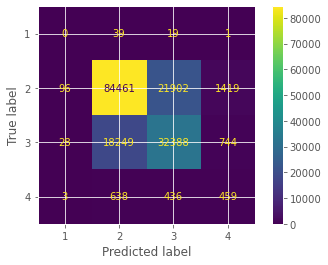

In [41]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print("My prediction: {}".format(clf_pred[0:20]))
print("Actual result: {}".format(y_test[0:20]))

predictions = pd.DataFrame(clf_pred)
print('Prediction value counts:', predictions[0].value_counts())

# accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, clf_pred)))

# f1 score
print('F1 Score:', f1_score(y_test, clf_pred, average='weighted'))

# recall score
print('Recall Score:', recall_score(y_test, clf_pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, clf_pred, labels=[1,2,3,4]))

print(classification_report(y_test, clf_pred, digits=4))

matrix = confusion_matrix(y_test, clf_pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

accuracy = 0.7553797192973732
F1 score: 0.7512422645219224
Recall score: 0.7553797192973732
[[[160811     12]
  [    59      0]]

 [[ 31001  22003]
  [ 16834  91044]]

 [[ 92335  17138]
  [ 21355  30054]]

 [[159144    202]
  [  1107    429]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        59
           2     0.8054    0.8440    0.8242    107878
           3     0.6368    0.5846    0.6096     51409
           4     0.6799    0.2793    0.3959      1536

    accuracy                         0.7554    160882
   macro avg     0.5305    0.4270    0.4574    160882
weighted avg     0.7500    0.7554    0.7512    160882

Accuracy per class: [0.         0.80536414 0.63684523 0.67987322]


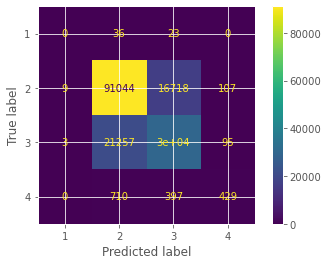

In [42]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                            max_features='auto',
                           random_state=0,
                           n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [46]:
#THIS OVERFITS THE TRAINING DATA, NOT GOOD
# rf = RandomForestClassifier(n_estimators=1000,
#                             max_features='auto',
#                            random_state=0,
#                             max_depth=10,
#                            n_jobs=-1)
# rf.fit(X_train, y_train)
                                     
# # Test Prediction
# pred = rf.predict(X_test)
# # print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
# print(f"accuracy = {rf.score(X_test, y_test)}")

# # f1 score
# print("F1 score:", f1_score(y_test, pred, average='weighted'))

# # recall score
# print("Recall score:", recall_score(y_test, pred, average='weighted'))

# print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

# print(classification_report(y_test, pred, digits=4))

# matrix = confusion_matrix(y_test, pred)
# acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

# print('Accuracy per class:', acc_per_class)

In [48]:
matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accurcay per class:', acc_per_class)

Accurcay per class: [0.         0.81639446 0.63104005 0.61574074]


In [49]:
# plt.figure(figsize=(20,20))
# cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# sns.heatmap(df_bl.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=16)
# plt.show()

## Score improved significantly after resampling:
- Previous RF scores: F1 0.64, Recall 0.63, Accuracy 0.83
- New RF scores: F1 0.889, Recall 0.89, Accuracy: 0.89


- Apparent issue: Year imbalance for Severity 1 accidents...
    - 5436 of 5801 total "Severity 1" accidents were in the year 2020.
    - After resampling, Severity 1 HEAVILY outweighs all other Severity levels in 2020.
    - Because of this, the "Year" column became a very important deciding factor but should it really be?
        - **Solution**: Take out all data from 2020 completely, and only look at 2016 - 2019

### Conclusion so far in the in the initial models before parameter tuning:
- It seems like the impact of "Year" column has decreased after the imbalance in severity distribution in each year was corrected. 
- RF: (Accuracy 0.895 | F1 0.895 | Recall 0.895)


- But were these models performed under the optimal parameters?
    - Run a GridSearchCV to find the optimal parameters
    - Best parameters:
        - {'bootstrap': True,
             'max_depth': 50,
             'max_features': 'auto',
             'min_samples_leaf': 3,
             'min_samples_split': 5,
             'n_estimators': 200}

In [50]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [3, 5, 10, 20, 50, 100],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5, 10],
#     'min_samples_split': [2, 5, 10, 12],
#     'n_estimators': [10, 20, 30, 50, 100, 200]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

In [51]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [20, 50],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [3, 5],
#     'min_samples_split': [5, 10],
#     'n_estimators': [50, 100]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

In [52]:
# Undersampling to do gridsearch

X = cldf[X_col]
y = cldf[y_col]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y, test_size=0.25)

sme = SMOTEENN(random_state=462,n_jobs=-1)

# usr = RandomUnderSampler(random_state=462) #this leads to only 11k rows
print('Original dataset shape %s' % Counter(y_train1))

X_train1, y_train1 = sme.fit_sample(X_train1, y_train1)
# X_train1, y_train1 = usr.fit_resample(X_train1, y_train1)

print('Resampled dataset shape %s' % Counter(y_train1))

Original dataset shape Counter({2: 323632, 3: 154229, 4: 4609, 1: 176})
Resampled dataset shape Counter({1: 323616, 4: 322240, 3: 184983, 2: 113247})


In [56]:
X_train.shape

(1294528, 28)

In [54]:
# Parameter Search                                     
model = RandomForestClassifier()

parameters = {'max_depth' : [45, 50],
             'n_estimators': [40, 50],
             'max_features': ['auto']}

scorer = make_scorer(accuracy_score)

clf = GridSearchCV(estimator=model,
                   param_grid=parameters,
                   cv=3,
                   scoring='recall_weighted',
                  verbose = 4, n_jobs=-1)

clf.fit(X_train1,y_train1)
# print(f"log loss = {-clf.score(X_test, y_test)}")
print(f"accuracy = {(clf.predict(X_test) == y_test).mean()}")
print(clf.best_params_)
print(clf.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  2.4min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  3.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.6min finished


accuracy = 0.6796844892529929
{'max_depth': 45, 'max_features': 'auto', 'n_estimators': 50}
RandomForestClassifier(max_depth=45, n_estimators=50)


In [55]:
# Train and fit model VERSION 2 (per GridSearchCV)                                                  
rf = RandomForestClassifier(n_estimators=50,
                            max_features='auto',
                           random_state=0,
                            max_depth=45,
                           n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)
print(matrix)
print('Accuracy per class:', acc_per_class)

accuracy = 0.7562934324535995
F1 score: 0.7525725917186248
Recall score: 0.7562934324535995
[[[160812     11]
  [    59      0]]

 [[ 31352  21652]
  [ 17065  90813]]

 [[ 92114  17359]
  [ 20973  30436]]

 [[159160    186]
  [  1111    425]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        59
           2     0.8075    0.8418    0.8243    107878
           3     0.6368    0.5920    0.6136     51409
           4     0.6956    0.2767    0.3959      1536

    accuracy                         0.7563    160882
   macro avg     0.5350    0.4276    0.4584    160882
weighted avg     0.7516    0.7563    0.7526    160882

[[    0    40    19     0]
 [    9 90813 16959    97]
 [    2 20882 30436    89]
 [    0   730   381   425]]
Accuracy per class: [0.         0.80747788 0.63680301 0.69558101]


In [43]:
#BEST ONE
# Train and fit model VERSION 2 (per GridSearchCV)                                                  
rf = RandomForestClassifier(n_estimators=200,
                            max_features='auto',
                           random_state=0,
                            max_depth=50,
                           n_jobs=-1)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

print(multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4]))

print(classification_report(y_test, pred, digits=4))

matrix = confusion_matrix(y_test, pred)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)
print(matrix)
print('Accuracy per class:', acc_per_class)

accuracy = 0.7601969145087704
F1 score: 0.7567616648296664
Recall score: 0.7601969145087704
[[[160814      9]
  [    59      0]]

 [[ 31843  21161]
  [ 16919  90959]]

 [[ 92249  17224]
  [ 20499  30910]]

 [[159160    186]
  [  1103    433]]]
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        59
           2     0.8113    0.8432    0.8269    107878
           3     0.6422    0.6013    0.6210     51409
           4     0.6995    0.2819    0.4019      1536

    accuracy                         0.7602    160882
   macro avg     0.5382    0.4316    0.4625    160882
weighted avg     0.7559    0.7602    0.7568    160882

[[    0    39    20     0]
 [    7 90959 16814    98]
 [    2 20409 30910    88]
 [    0   713   390   433]]
Accuracy per class: [0.         0.81126472 0.64216562 0.69951535]


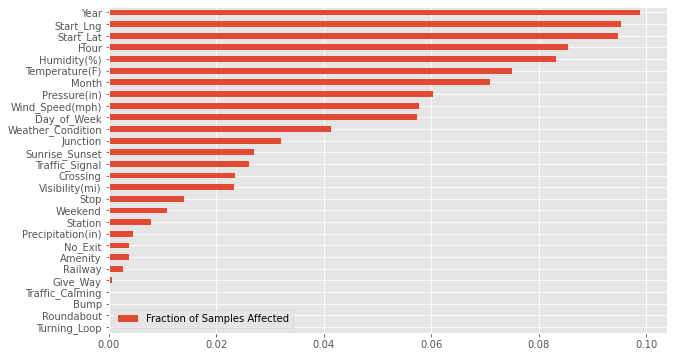

In [45]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(10,6))